In [1]:
import numpy as np
import pandas as pd 
import os
import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split
import sklearn.linear_model
from sklearn.utils import resample
import joblib

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.utils.class_weight import compute_sample_weight

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
# change os directory up one level
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))
from api_helpers.game_stats_helpers import load_past_n_games
# change os directory back 
os.chdir(os.path.join(os.getcwd(), 'selected_models'))

#print directory


## Data Preparation

In [2]:
def get_data():
    all_games_df = pd.read_csv("../data/all_games.csv",encoding="utf-8")
    all_games_df.drop("Unnamed: 0", axis=1,inplace=True)
    all_games_df = all_games_df.dropna()
    all_games_df = all_games_df[all_games_df['WL_A'] != ' ']
    X = all_games_df.drop(columns=["WL_A", "WL_B", 'SEASON_ID', 'TEAM_ID_A', 'TEAM_ABBREVIATION_A', 'TEAM_NAME_A',
       'GAME_ID', 'GAME_DATE', 'MATCHUP_A', 'MIN_A', 'TEAM_ID_B', 'TEAM_ABBREVIATION_B','TEAM_NAME_B', 'MATCHUP_B'])
    y = all_games_df["WL_A"]
    le = skp.LabelEncoder()
    y = le.fit_transform(y)
    return all_games_df, X, y

def data_prep(all_games_df, columns=["FG_PCT","FT_PCT", "OREB", "TOV", "DREB", "AST"]):
    columns_a = [column + "_A" for column in columns]
    columns_b = [column + "_B" for column in columns]

    n_games_df = load_past_n_games(all_games_df=all_games_df, columns=columns, n=20)
    n_games_df = n_games_df.dropna()

    x_columns = columns_a + columns_b
    y_column = "WL_A"

    #normalize x_data
    scaler = skp.StandardScaler()
    n_games_df[x_columns] = scaler.fit_transform(n_games_df[x_columns])
    # save scaler
    # joblib.dump(scaler, 'knn_scaler.bin')

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(n_games_df[x_columns], n_games_df[y_column], test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [3]:
all_games_df, X,y = get_data()
print(X.columns)

Index(['PTS_A', 'FGM_A', 'FGA_A', 'FG_PCT_A', 'FG3M_A', 'FG3A_A', 'FG3_PCT_A',
       'FTM_A', 'FTA_A', 'FT_PCT_A', 'OREB_A', 'DREB_A', 'REB_A', 'AST_A',
       'STL_A', 'BLK_A', 'TOV_A', 'PF_A', 'PLUS_MINUS_A', 'MIN_B', 'PTS_B',
       'FGM_B', 'FGA_B', 'FG_PCT_B', 'FG3M_B', 'FG3A_B', 'FG3_PCT_B', 'FTM_B',
       'FTA_B', 'FT_PCT_B', 'OREB_B', 'DREB_B', 'REB_B', 'AST_B', 'STL_B',
       'BLK_B', 'TOV_B', 'PF_B', 'PLUS_MINUS_B'],
      dtype='object')


## Feature Selection

In [11]:
# using Recursive Feature Elimination (RFE) to get best features
# Apply RFE
from sklearn.feature_selection import RFE
import sklearn.ensemble
import sklearn.linear_model

estimator = sklearn.ensemble.RandomForestRegressor() # using RandomForestRegressor is arbitrary, it worked better than logistic and linear
selector = RFE(estimator, n_features_to_select=12, step=1)
selector = selector.fit(X, y)
selected_columns = X.columns[selector.support_]
selected_columns

Index(['PTS_A', 'FG_PCT_A', 'FG3A_A', 'FG3_PCT_A', 'PLUS_MINUS_A', 'PTS_B',
       'FG_PCT_B', 'FG3M_B', 'FTA_B', 'FT_PCT_B', 'PF_B', 'PLUS_MINUS_B'],
      dtype='object')

## Train Model

In [10]:
columns = ["PTS", "FG_PCT", "PLUS_MINUS", "DREB", "OREB", "TOV", "AST"]
X_train, X_test, y_train, y_test = data_prep(all_games_df, columns=columns)

# knn model
knn_model = sklearn.neighbors.KNeighborsClassifier()
param_grid = {
    'n_neighbors': [140, 150, 160, 180, 200, 220, 250],
}
# grid search
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy', refit=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
knn_model = grid_search.best_estimator_
y_pred = knn_model.predict(X_test)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ....................................n_neighbors=140; total time=   2.8s
[CV] END ....................................n_neighbors=140; total time=   2.8s
[CV] END ....................................n_neighbors=150; total time=   2.9s
[CV] END ....................................n_neighbors=150; total time=   2.9s
[CV] END ....................................n_neighbors=150; total time=   2.9s
[CV] END ....................................n_neighbors=140; total time=   3.7s
[CV] END ....................................n_neighbors=150; total time=   3.6s
[CV] END ....................................n_neighbors=140; total time=   3.8s
[CV] END ....................................n_neighbors=140; total time=   4.1s
[CV] END ....................................n_neighbors=150; total time=   4.2s
[CV] END ....................................n_neighbors=160; total time=   2.7s
[CV] END ....................................n_ne

Classification Report:
              precision    recall  f1-score   support

           L       0.56      0.23      0.33      3067
           W       0.63      0.88      0.73      4522

    accuracy                           0.61      7589
   macro avg       0.59      0.55      0.53      7589
weighted avg       0.60      0.61      0.57      7589



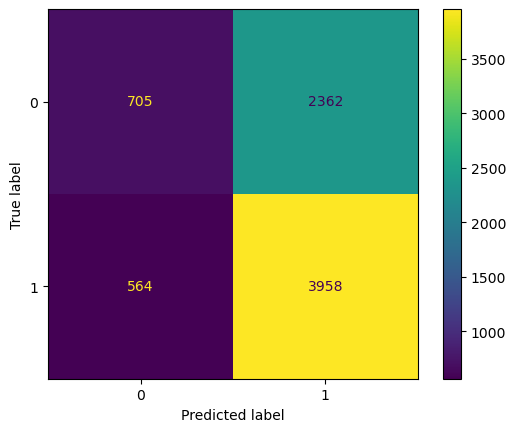

In [11]:
report = metrics.classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()

In [12]:
# save model
joblib.dump(knn_model, 'knn_model.bin')

# load model
knn_model = joblib.load('knn_model.bin')

knn_model.predict(X_test)

array(['L', 'W', 'W', ..., 'W', 'W', 'L'], dtype=object)